# Exploring ODF Extraction
## Sam Potter
## Current: 4/819

## Path and Imports

In [1]:
import sys
import os

sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
from dic import visualize
from dic import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from dic import utilities
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt

## Magics

In [2]:
%matplotlib inline

## Optical Mathematics

### Cylindrical scattering for single fiber

$I_{fiber}(\theta) = a_0 + a_2 \cos(2(\theta - \phi)) + a_4 \cos(4(\theta - \phi))$

### Cylindrical scattering for a distribution of fibers

$I_{dist}(\theta) = \int_{-\pi/2}^{\pi/2} I_{fiber}(\theta) PDF_{dist}(\theta) d \theta$

NOTE, CONVOLUTION OPERATION IS TREATED AS JUST SUMMATION AND NORMALIZATION IN THE WORK BELOW. CORRECT???

## Setup Single Fiber Cosine Series

### Definition of single fiber function

In [3]:
def Ifiber(a0, a2, a4, phi, numpts=100, normalize=True):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    if normalize:
        vals = utilities.normalize_1d(vals)
    
    return vals, theta

In [4]:
def Ifiber_interactive(a0, a2, a4, phi, numpts=100, normalize=True):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    if normalize:
        vals = utilities.normalize_1d(vals)
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(theta, vals, color='g', label='Intensity');
    plt.legend(prop={'size': 18});
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Normalized Intensity (a.u.)', fontsize=18);
    plt.title('Normalized Intensity Curves of Single Fiber under Cylindrical Scattering', fontsize=18);
    plt.autoscale(enable=True, axis='x', tight=True)
    
    print('a2/a4: {}'.format(a2/a4))

### Plot a sample intensity function

In [5]:
p = interactive(Ifiber_interactive, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi=(-90, 90, 5), numpts=(100, 500, 10))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## Look at Fiber Distributions

### Setup Uniform Distribution

In [6]:
samples = np.random.uniform(-45, 45, 10000)

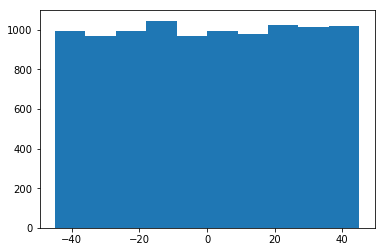

In [7]:
plt.hist(samples);

### Setup Normal Distribution

In [8]:
samples = np.random.normal(0, 45, 10000)

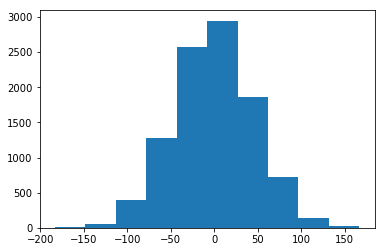

In [9]:
plt.hist(samples);

### Setup and generate samples

In [10]:
def syntheticIdist(a0, a2, a4, splay, nsamples, distribution='uniform'):
    
    ntheta = 100
    Idist = np.zeros((nsamples, ntheta))
    for i in range(0, nsamples):
        if distribution == 'uniform':
            phi = np.random.uniform(-1*splay, splay)
        elif distribution == 'normal':
            phi = np.random.normal(0, splay)

        vals, theta_dist = Ifiber(a0, a2, a4, phi, numpts=ntheta, normalize=False)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0) / nsamples
    #Idist = utilities.normalize_1d(Idist)
    
    return Idist

In [11]:
def compareI(a0, a2, a4, phi0, splay, nsamples, distribution='uniform'):
    
    ntheta = 100
    Idist = np.zeros((nsamples, ntheta))
    if distribution == 'uniform':
        phis = np.random.uniform(-1*splay, splay, nsamples)
    elif distribution == 'normal':
        phis = np.random.normal(0, splay, nsamples)
    for i in range(0, nsamples):
        phi = phis[i]
        vals, theta_dist = Ifiber(a0, a2, a4, phi, numpts=ntheta, normalize=False)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0) / nsamples
    #Idist = utilities.normalize_1d(Idist)
    
    Ifibers, theta_fiber = Ifiber(a0, a2, a4, phi0, numpts=ntheta, normalize=False)
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(theta_fiber, Ifibers, color='g', label='Single Fiber Intensity');
    plt.plot(theta_dist, Idist, color='r', label='Fiber Distribution Intensity');
    plt.legend(prop={'size': 14}, loc='best');
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Intensity (a.u.)', fontsize=18);
    plt.title('Intensity Curves from Single Fiber and a Distribution of Fibers', fontsize=18);
    #plt.ylim(0, 1.25)
    plt.autoscale(enable=True, axis='x', tight=True)
    
    fig = plt.figure(figsize=(10, 10))
    plt.hist(phis)
    plt.title('Historgram of phi')
    plt.xlabel('phi')
    

In [12]:
p = interactive(compareI, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi0=(-90, 90, 5), splay=(0, 90, 5), nsamples=(10, 10000, 100))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## See if I can fit the new a0, a2, and a4 terms from the Idist

In [13]:
def minimand(a0, a2, a4, phi, data):
    
    theta = np.linspace(-90, 90, len(data))
    
    feval = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    diff = data - feval
    
    diffsq = np.square(diff, diff)
    
    ssd = np.sum(diffsq)
    
    return ssd

In [14]:
def minfun(params, *args):

    return minimand(params[0], params[1], params[2], params[3], *args)

In [15]:
a0 = 0
a2 = 0.0652
a4 = 0.2489
phi = 0
splay = 30
nsamples = 10000
Isingle_data, theta_single = Ifiber(a0, a2, a4, phi, normalize=False)
Idist_data = syntheticIdist(a0, a2, a4, splay, nsamples, distribution='normal')
minimand(a0, a2, a4, phi, Idist_data)

2.567689230962088

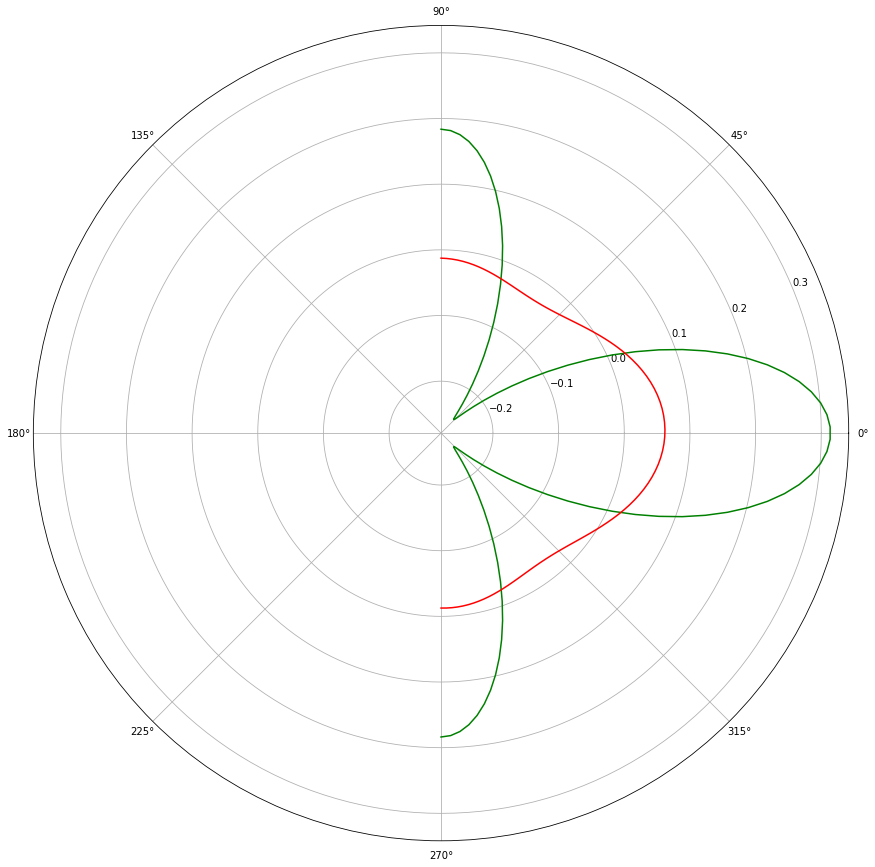

In [28]:
theta = np.linspace(-90, 90, 100)
# Plot Polar
fig = plt.figure(figsize=(15, 15))
plt.polar(np.deg2rad(theta), Isingle_data, color='g', label='Mean Fiber Intensity');
plt.polar(np.deg2rad(theta), Idist_data, color='r', label='SALS ODF');

### Find the distribution terms

### Plot the data first

In [ ]:

fig = plt.figure(figsize=(10, 10))
plt.plot(theta, Isingle_data, color='g', label='Reference Single Fiber Intensity')
plt.plot(theta, Idist_data, color='r', label='Fiber Distribution Intensity');
plt.legend(prop={'size': 14}, loc='best');
plt.xlabel(r'$\theta$', fontsize=18);
plt.ylabel('Intensity (a.u.)', fontsize=18);
plt.ylim(-.5, .5);

### Minimize to find the parameter values

In [ ]:
args_tup = (Idist_data)
int_x = np.array([.6, 0.025, .15, 0])
bounds = ((0, 1), (-1, 1), (0, 1), (-90, 90))
res = sciopt.minimize(minfun, int_x, args=args_tup, bounds=bounds, method='L-BFGS-B', jac='2-point')

In [ ]:
print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

### Plot fit results

In [ ]:
a0f = res.x[0]
a2f = res.x[1]
a4f = res.x[2]
phif = res.x[3]

Ifit, theta_fit = Ifiber(a0f, a2f, a4f, phif, normalize=False)

In [ ]:
theta = np.linspace(-90, 90, 100)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, Isingle_data, color='g', label='Reference Single Fiber Intensity')
plt.plot(theta, Idist_data, color='r', label='Fiber Distribution Intensity');
plt.plot(theta, Ifit, color='k', ls='dashed', label='Fit Distribution Intensity')
plt.legend(prop={'size': 14}, loc='best');
plt.xlabel(r'$\theta$', fontsize=18);
plt.ylabel('Intensity (a.u.)', fontsize=18);
plt.ylim(-.5, .5);
print('Single Fiber a2: {}, a4: {} and a2/a4: {}'.format(a2, a4, a2/a4))
print('Fit Fiber Distribution a2: {}, a4: {} and a2/a4: {}'.format(a2f, a4f, a2f/a4f))

### Fit single fiber ai terms by convolving with SALS SD

In [ ]:
# Functions
def sals_syntheticIdist(a0, a2, a4, phi_mean, splay, nsamples, distribution='uniform'):
    
    ntheta = 100
    Idist = np.zeros((nsamples, ntheta))
    for i in range(0, nsamples):
        if distribution == 'uniform':
            phi = np.random.uniform(phi_mean - 1*splay, phi_mean + splay)
        elif distribution == 'normal':
            phi = np.random.normal(phi_mean, splay)

        vals, theta_dist = Ifiber(a0, a2, a4, phi, numpts=ntheta, normalize=False)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0) / nsamples
    #Idist = utilities.normalize_1d(Idist)
    
    return Idist

# minimand for finding single fiber ai from measured SALS sd and measured pSFDI fiber distribution ai
def sals_minimand(a0, a2, a4, phi_mean, sigma, psfdi_data):
    
    synthetic_Idist = sals_syntheticIdist(a0, a2, a4, phi_mean, sigma, 10000, distribution='normal')
    
    diff = psfdi_data - synthetic_Idist
    
    diffsq = np.square(diff, diff)
    
    ssd = np.sum(diffsq)
    
    return ssd

def sals_minfun(params, *args):
    
    return sals_minimand(params[0], params[1], params[2], params[3], *args)

### Try a synthetic example first


In [ ]:
# Generate synthetic data
a0_s_synth = 0.5
a2_s_synth = 0.025
a4_s_synth = 0.1
phi_s_synth = 0
sigma_d_synth = 45

synthetic_single_fiber, theta = Ifiber(a0_s_synth, a2_s_synth, a4_s_synth, phi_s_synth, normalize=False) 
synthetic_measured_distribution = sals_syntheticIdist(a0_s_synth, a2_s_synth, a4_s_synth, phi_s_synth, sigma_d_synth, 10000, distribution='normal')

In [ ]:
# Plot
theta = np.linspace(-90, 90, 100)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, synthetic_single_fiber, color='g', label='Synthetic Single Fiber Intensity');
plt.plot(theta, synthetic_measured_distribution, color='r', label='Synthetic Distribution Intensity');
plt.title('Synthetic single fiber and generated synthetic distribution')
plt.legend();
plt.xlabel('theta')
plt.ylabel('Intensity [a.u.]');
plt.autoscale(enable=True, axis='x', tight=True)

In [ ]:
# Fit data to get synthetic distribution ai and phi
args_tup = (synthetic_measured_distribution)
#int_x = np.array([a0_s_synth, a2_s_synth, a4_s_synth, phi_s_synth]) -- Weird local minimums
int_x = np.array([0, 0, 0, theta[np.argmax(synthetic_measured_distribution)]])  # Just make it easier and guess all zeros
bounds = ((0, 1), (-1, 1), (0, 1), (-90, 90))
res = sciopt.minimize(minfun, int_x, args=args_tup, bounds=bounds, method='L-BFGS-B', jac='2-point')

print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

a0_d_synth = res.x[0]
a2_d_synth = res.x[1]
a4_d_synth = res.x[2]
phi_d_synth = res.x[3]

fit_distribution, theta = Ifiber(a0_d_synth, a2_d_synth, a4_d_synth, phi_d_synth, normalize=False)

In [ ]:
# Plot the fit data
theta = np.linspace(-90, 90, 100)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, synthetic_single_fiber, color='g', label='Synthetic Single Fiber Intensity');
plt.plot(theta, synthetic_measured_distribution, color='r', label='Synthetic Distribution Intensity');
plt.plot(theta, fit_distribution, color='k', ls='dashed', label='Fit Ditribution Intensity');
plt.title('Synthetic Single Fiber and Fiber Distribution Along with Fit Fiber Distribution')
plt.legend();
plt.xlabel('theta');
plt.ylabel('Intensity [a.u.]');
plt.autoscale(enable=True, axis='x', tight=True)

### Try to find terms via gradient based optimization

In [ ]:
args = (sigma_d_synth, synthetic_measured_distribution)
int_x = np.array([0, 0, 0, 0])  # Just guess all zeros
bounds = ((0, 1), (-1, 1), (0, 1), (-90, 90))
res = sciopt.minimize(sals_minfun, int_x, args=args, bounds=bounds, method='L-BFGS-B', jac='2-point')

In [ ]:
print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

In [ ]:
a0_s_fit = res.x[0]
a2_s_fit = res.x[1]
a4_s_fit = res.x[2]
phi_s_fit = res.x[3]

fit_single, theta = Ifiber(a0_s_fit, a2_s_fit, a4_s_fit, phi_s_fit, normalize=False)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, synthetic_single_fiber, color='g', label='Synthetic Single Fiber Intensity')
plt.plot(theta, fit_single, color='k', ls='dashed', label='Fit Single Fiber Intensity');
plt.title('Synthetic Single Fiber vs Fit Single Fiber');
plt.xlabel('theta')
plt.ylabel('Intensity [a.u.]');
plt.legend();
plt.autoscale(enable=True, axis='x', tight=True);

### Try to find terms via global optimization

In [ ]:
res = sciopt.differential_evolution(sals_minfun, bounds, args=args, maxiter=100)

In [ ]:
print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

In [ ]:
# Plot single fiber and measured distribution
Isingle, theta = Ifiber(res.x[0], res.x[1], res.x[2], res.x[3], normalize=False)

fig = plt.figure(figsize=(10, 10))
plt.plot(theta, Isingle, label='Estimated Single Fiber Intensity')
plt.plot(theta, ivals, label='Measured Fiber Distribution Intensity');
plt.legend();
plt.title('Estimated Single Fiber vs Measured Fiber Distribution - Single Fiber a_i Terms from Global Opt')
plt.ylabel('Intensity [a.u.]')
plt.xlabel('theta')
plt.autoscale(enable=True, axis='x', tight=True)